In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy.stats as ss
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
def locate_index(value,bin_min,step_size,precision):
  loc0 = (value-bin_min)/step_size
  if loc0 < 0:
    loc = 0
  elif loc0 >= precision:
    loc = precision-1
  else:
    loc = int(loc0)
  return loc

In [3]:
def shift_hist(old_hist,shift):
  if shift<0:
    left_end = sum(old_hist[:(abs(shift)+1)])
    rest = old_hist[(abs(shift)+1):]
    fill = np.zeros(len(old_hist)-1-len(rest))
    new_hist = np.concatenate(([left_end],rest,fill))
  elif shift>0:
    right_end = sum(old_hist[-(abs(shift)+1):])
    rest = old_hist[:-(abs(shift)+1)]
    fill = np.zeros(len(old_hist)-1-len(rest))
    new_hist = np.concatenate((fill,rest,[right_end]))
  else:
    new_hist = old_hist
  return new_hist

In [4]:
def hist2quantile(hist_j,loc):
  cumsum = np.cumsum(np.sum(hist_j,axis=0))
  n = cumsum[-1]
  rank = (cumsum[loc]+1)/(n+2)
  q = ss.norm.ppf(rank)
  return q

In [5]:
def get_ranks(eps):
  temp = eps.argsort()
  ranks = np.empty_like(temp)
  ranks[temp] = np.arange(len(eps))
  return ranks

In [6]:
def argsort2rank(argsort):
  ranks = np.zeros(len(argsort))
  for i in range(len(argsort)):
    ranks[argsort[i]] = i
  return ranks

In [7]:
def initialize_hist_toy(eps,period,r,precision):
  eps_hist = np.zeros((period,precision))
  diff = max(eps)-min(eps)
  bin_min = min(eps)-r*diff
  bin_max = max(eps)+r*diff
  step_size = (bin_max-bin_min)/precision
  for i in range(len(eps)):
    loc = locate_index(eps[i],bin_min,step_size,precision)
    eps_hist[i%period, loc] = eps_hist[i%period, loc]+1
  total_hist = np.sum(eps_hist,axis=0,dtype = int)
  final_rank = argsort2rank(total_hist[total_hist>0]-1)
  return final_rank

In [10]:
def initialize_hist_uni(eps,period,r,precision):
  eps_hist = np.zeros((period,precision))
  diff = max(eps)-min(eps)
  bin_min = min(eps)-r*diff
  bin_max = max(eps)+r*diff
  step_size = (bin_max-bin_min)/precision
  for i in range(len(eps)):
    loc = locate_index(eps[i],bin_min,step_size,precision)
    eps_hist[i%period, loc] = eps_hist[i%period, loc] + 1 
  density = np.sum(eps_hist,axis=0,dtype = int)
  cum_hist = np.cumsum(density)
  return density, cum_hist

In [11]:
def update_hist_uni(density,cum_hist,new_eps,bin_min,step_size,precision):
  new_loc = locate_index(new_eps,bin_min,step_size,precision)
  new_rank = cum_hist[new_loc]
  density[new_loc] = density[new_loc] + 1
  cum_hist = np.cumsum(density)
  return density,cum_hist,new_rank

In [12]:
### simulation
period = 7
r = 0.15
g = 50
N = 3000
corr_sum = np.zeros((3,N-100-g))
diff_sum = np.zeros((3,N-100-g))
for rep in range(5):
  corr_mat = np.zeros((3,N-100-g))
  diff_mat = np.zeros((3,N-100-g))
  all_eps = np.random.normal(size=N)
  old_data = all_eps[:100]
  new_data = all_eps[100:]
  diff = max(old_data)-min(old_data)
  bin_min = min(old_data)-r*diff
  bin_max = max(old_data)+r*diff
  for k in range(3):
    ranks_old = []
    ranks_new = []
    corr = []
    diff = []
    precision = np.array([50,100,500])[k]
    step_size = (bin_max-bin_min)/precision
    density, cum_hist = initialize_hist_uni(old_data,period,r,precision)
    for i in range(len(new_data)):
      rank_old = get_ranks(all_eps[:(100+i+1)])[-1]
      ranks_old.append(rank_old)
      density,cum_hist,rank_new = update_hist_uni(density,cum_hist,new_data[i],bin_min,step_size,precision)
      ranks_new.append(rank_new)
    ranks_old = np.array(ranks_old)
    ranks_new = np.array(ranks_new)
    for i in np.arange(g,len(ranks_new)):
      index = np.arange(i-g,i)
      corr.append(ss.spearmanr(ranks_new[index],ranks_old[index])[0])
      diff.append(np.mean((abs(ranks_old[index]-ranks_new[index]))))
    corr = np.array(corr)
    diff = np.array(diff)
    corr_mat[k,:] = corr
    diff_mat[k,:] = diff
  corr_sum = corr_sum + corr_mat
  diff_sum = diff_sum + diff_mat

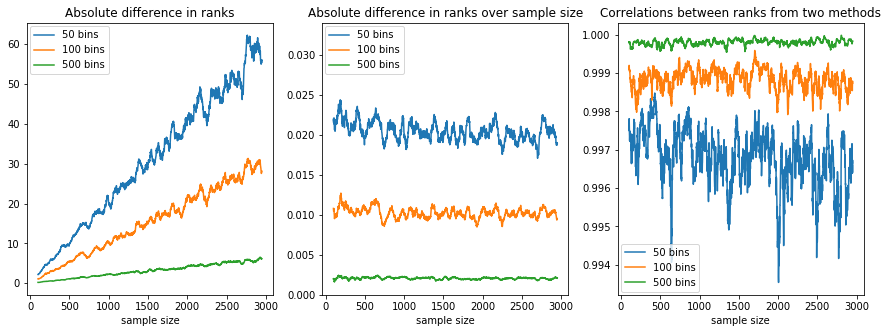

In [13]:
labels = ['50 bins', '100 bins','500 bins']
plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.subplot(1, 3, 1)
for k in range(3):
  plt.plot(np.arange(100,N-g),(diff_sum/5)[k,:],label = labels[k])
  plt.xlabel('sample size')
  plt.title("Absolute difference in ranks")
  plt.legend(loc="upper left", borderaxespad=0.3)
  
plt.subplot(1, 3, 2)
for k in range(3):
  plt.plot(np.arange(100,N-g),(diff_sum/5)[k,:]/np.arange(100,N-g),label = labels[k])
  plt.xlabel('sample size')
  plt.ylim(0,0.034)
  plt.title("Absolute difference in ranks over sample size")
  plt.legend(loc="upper left", borderaxespad=0.3)
  
plt.subplot(1, 3, 3)
for k in range(3):
  plt.plot(np.arange(100,N-g),(corr_sum/5)[k,:],label = labels[k])
  plt.xlabel('sample size')
  plt.title("Correlations between ranks from two methods")
  plt.legend(loc="lower left", borderaxespad=0.3)
plt.savefig("rank_comparison.pdf")

In [14]:
def initialize_hist_mu0(data,period,r,precision):
  hist_dict = {}
  (nrow,ncol) = data.shape
  eps_tilde_mat = data
  bin_min_vec = np.zeros(ncol)
  step_size_vec = np.zeros(ncol)
  day_sum_mat = np.zeros((period,ncol))
  temporal_index = np.arange(nrow)
  periodic_index = temporal_index%period
  count = np.array([sum(periodic_index==k) for k in range(period)])
  for j in range(ncol):
    y_minus_mu = data[:,j] 
    eps_hist = np.zeros((period,precision))
    day_sum = np.array([sum(y_minus_mu[periodic_index==k]) for k in range(period)])
    s = day_sum/count
    eps = np.array([y_minus_mu[k]-s[k%period] for k in range(nrow)])
    rank = get_ranks(eps)
    eps_tilde = ss.norm.ppf((rank+1)/(nrow+1))
    eps_tilde_mat[:,j] = eps_tilde
    diff = max(eps)-min(eps)
    bin_min = min(eps)-r*diff
    bin_min_vec[j] = bin_min
    bin_max = max(eps)+r*diff
    step_size = (bin_max-bin_min)/precision
    step_size_vec[j] = step_size
    for i in range(nrow):
      row_loc = i%period
      col_loc = locate_index(eps[i],bin_min,step_size,precision)
      eps_hist[row_loc, col_loc]=eps_hist[row_loc, col_loc]+1
    hist_dict[str(j)] = eps_hist
    day_sum_mat[:,j] = day_sum
  var = np.cov(eps_tilde_mat,rowvar=False)
  return hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,var,eps_tilde_mat[-1,:]

In [15]:
def online_update_mu0(new_input,hist_dict,day_sum_mat,count,var):
  (period, ncol) = day_sum_mat.shape
  n = sum(count)
  eps_vec = np.zeros(ncol)
  count[n%period] = count[n%period] + 1
  for j in range(ncol):
    y_minus_mu = new_input[j]
    old_avg = day_sum_mat[n%period,j]/(count[n%period]-1)
    day_sum_mat[n%period,j] = day_sum_mat[n%period,j] +  y_minus_mu
    new_avg = day_sum_mat[n%period,j]/count[n%period] 
    new_eps = y_minus_mu - new_avg
    loc = locate_index(new_eps,bin_min_vec[j],step_size_vec[j],precision)
    quantile = hist2quantile(hist_dict[str(j)],loc)
    eps_vec[j] = quantile
    shift = int(np.round((old_avg-new_avg)/step_size_vec[j],0))
    old_hist = hist_dict[str(j)][n%period,:]
    new_hist = shift_hist(old_hist,shift)
    new_hist[loc] = new_hist[loc] + 1
    hist_dict[str(j)][n%period,:] = new_hist
  cov = n/(n+1)*var+1/(n+1)*np.outer(eps_vec,eps_vec)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  var[cov==0] = 0
  stat = eps_vec.dot(np.linalg.inv(var)).dot(eps_vec)
  return stat,hist_dict,day_sum_mat,count,var,eps_vec

In [16]:
np.random.seed(222)
n = 3000
mu = 0
p = 20
r = 0.15
period = 7
precisions = [50,100,500]
s = np.zeros((p,7))
for j in range(p):
  for i in range(7):
    s[j,i] = np.random.normal(loc=0,scale=2,size=1)
s_mat = np.zeros((n,p))
for j in range(p):
  for i in range(7):
    s_mat[np.arange(i,n,7),j] = s[j,i]
cov = np.ones((p,p))*0.7
for i in range(p):
  cov[i,i]=1
  
eps1 = np.random.normal(size = p*n).reshape((n,p))
eps2 = ss.gamma.rvs(2,scale=2, size = p*n).reshape((n,p)) 
eps2 = eps2 - np.mean(eps2)
eps3 = ss.multivariate_normal.rvs(cov=cov,size=n)
data1 = s_mat + eps1
data2 = s_mat + eps2
data3 = s_mat + eps3

In [17]:
## check if the code is right
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,var,eps= initialize_hist_mu0(data1[:101,:],period,r,precision)
eps

array([ 0.54139509, -0.14798711,  0.22300783,  1.23808034,  0.65914304,
       -0.09845799,  0.37739194,  0.62890422, -1.75986103,  0.59922987,
       -0.19788217, -1.13852348, -0.14798711, -0.82079209, -0.7868451 ,
        1.23808034,  0.19788217,  0.59922987, -0.37739194,  0.68999699])

In [18]:
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,var,eps= initialize_hist_mu0(data1[:100,:],period,r,precision)
stat,hist_dict,day_sum_mat,count,var,eps_vec = online_update_mu0(data1[100,:],hist_dict,day_sum_mat,count,var)
eps_vec

array([ 0.54139509, -0.14798711,  0.22300783,  1.23808034,  0.62890422,
       -0.04916938,  0.45785193,  0.62890422, -1.75986103,  0.57007409,
       -0.17288083, -1.13852348, -0.14798711, -0.82079209, -0.7868451 ,
        1.23808034,  0.22300783,  0.57007409, -0.37739194,  0.68999699])

In [19]:
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,var,eps = initialize_hist_mu0(data1[:102,:],period,r,precision)
eps

array([ 2.3374177 ,  1.29832768, -0.2583763 ,  1.01379703, -0.38663138,
       -0.54970129, -2.3374177 , -1.89379348,  1.35707531,  1.05535688,
       -2.3374177 , -1.65914102,  1.65914102,  1.14447383, -2.06593146,
        0.97391834,  0.72897097, -0.57823304, -2.3374177 ,  1.09882442])

In [20]:
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,var,eps= initialize_hist_mu0(data1[:100,:],period,r,precision)
stat,hist_dict,day_sum_mat,count,var,eps_vec = online_update_mu0(data1[100,:],hist_dict,day_sum_mat,count,var)
stat,hist_dict,day_sum_mat,count,var,eps_vec = online_update_mu0(data1[101,:],hist_dict,day_sum_mat,count,var)
eps_vec

array([ 2.3374177 ,  1.29832768, -0.23329289,  1.01379703, -0.38663138,
       -0.52161022, -2.3374177 , -1.89379348,  1.35707531,  1.05535688,
       -2.3374177 , -1.65914102,  1.65914102,  1.14447383, -2.06593146,
        0.97391834,  0.72897097, -0.57823304, -2.3374177 ,  1.09882442])

In [21]:
## variance simulation
## p = 20
np.random.seed(222)
n = 3000
mu = 0
p = 20
r = 0.15
period = 7
precisions = [50,100,500]
s = np.zeros((p,7))
for j in range(p):
  for i in range(7):
    s[j,i] = np.random.normal(loc=0,scale=2,size=1)
s_mat = np.zeros((n,p))
for j in range(p):
  for i in range(7):
    s_mat[np.arange(i,n,7),j] = s[j,i]
true_cov = np.ones((p,p))*0.7
for i in range(p):
  true_cov[i,i]=1
  
eps1 = np.random.normal(size = p*n).reshape((n,p))
eps2 = ss.gamma.rvs(2,scale=2, size = p*n).reshape((n,p)) 
eps2 = eps2 - np.mean(eps2)
eps3 = ss.multivariate_normal.rvs(cov=true_cov,size=n)
data1 = s_mat + eps1
data2 = s_mat + eps2
data3 = s_mat + eps3

In [22]:
## p20_scenario 1
f_norm_old = []
f_norm_new = []
f_diff = []
data = data1
p = data.shape[1]
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,new_var,eps = initialize_hist_mu0(data[:100,:],period,r,precision)
for i in np.arange(101,3001):
  hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,old_var,eps = initialize_hist_mu0(data[:i,:],period,r,precision)
  cov = (i-1)/i*new_var + 1/i*np.outer(eps,eps)
  std = np.sqrt(np.diag(cov))
  new_var = cov/np.outer(std,std)
  new_var[cov==0] = 0
  f_norm_new.append(np.linalg.norm(new_var-np.eye(p), ord="fro"))
  f_norm_old.append(np.linalg.norm(old_var-np.eye(p), ord="fro"))
  f_diff.append(np.linalg.norm(new_var-old_var, ord="fro"))
f_norm_new_p20_s1 = f_norm_new
f_norm_old_p20_s1 = f_norm_old
f_diff_p20_s1 = f_diff

In [23]:
## p = 40
np.random.seed(222)
n = 3000
mu = 0
p = 40
r = 0.15
period = 7
precisions = [50,100,500]
s = np.zeros((p,7))
for j in range(p):
  for i in range(7):
    s[j,i] = np.random.normal(loc=0,scale=2,size=1)
s_mat = np.zeros((n,p))
for j in range(p):
  for i in range(7):
    s_mat[np.arange(i,n,7),j] = s[j,i]
true_cov = np.ones((p,p))*0.7
for i in range(p):
  true_cov[i,i]=1
  
eps1 = np.random.normal(size = p*n).reshape((n,p))
eps2 = ss.gamma.rvs(2,scale=2, size = p*n).reshape((n,p)) 
eps2 = eps2 - np.mean(eps2)
eps3 = ss.multivariate_normal.rvs(cov=true_cov,size=n)
data1 = s_mat + eps1
data2 = s_mat + eps2
data3 = s_mat + eps3

In [24]:
## p40_scenario 1
f_norm_old = []
f_norm_new = []
f_diff = []
data = data1
p = data.shape[1]
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,new_var,eps = initialize_hist_mu0(data[:100,:],period,r,precision)
for i in np.arange(101,3001):
  hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,old_var,eps = initialize_hist_mu0(data[:i,:],period,r,precision)
  cov = (i-1)/i*new_var + 1/i*np.outer(eps,eps)
  std = np.sqrt(np.diag(cov))
  new_var = cov/np.outer(std,std)
  new_var[cov==0] = 0
  f_norm_new.append(np.linalg.norm(new_var-np.eye(p), ord="fro"))
  f_norm_old.append(np.linalg.norm(old_var-np.eye(p), ord="fro"))
  f_diff.append(np.linalg.norm(new_var-old_var, ord="fro"))
f_norm_new_p40_s1 = f_norm_new
f_norm_old_p40_s1 = f_norm_old
f_diff_p40_s1 = f_diff

In [25]:
## p = 80
np.random.seed(222)
n = 3000
mu = 0
p = 80
r = 0.15
period = 7
precisions = [50,100,500]
s = np.zeros((p,7))
for j in range(p):
  for i in range(7):
    s[j,i] = np.random.normal(loc=0,scale=2,size=1)
s_mat = np.zeros((n,p))
for j in range(p):
  for i in range(7):
    s_mat[np.arange(i,n,7),j] = s[j,i]
true_cov = np.ones((p,p))*0.7
for i in range(p):
  true_cov[i,i]=1
  
eps1 = np.random.normal(size = p*n).reshape((n,p))
eps2 = ss.gamma.rvs(2,scale=2, size = p*n).reshape((n,p)) 
eps2 = eps2 - np.mean(eps2)
eps3 = ss.multivariate_normal.rvs(cov=true_cov,size=n)
data1 = s_mat + eps1
data2 = s_mat + eps2
data3 = s_mat + eps3

In [26]:
## p80_scenario 1
f_norm_old = []
f_norm_new = []
f_diff = []
data = data1
p = data.shape[1]
hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,new_var,eps = initialize_hist_mu0(data[:100,:],period,r,precision)
for i in np.arange(101,3001):
  hist_dict,day_sum_mat,count,bin_min_vec,step_size_vec,old_var,eps = initialize_hist_mu0(data[:i,:],period,r,precision)
  cov = (i-1)/i*new_var + 1/i*np.outer(eps,eps)
  std = np.sqrt(np.diag(cov))
  new_var = cov/np.outer(std,std)
  new_var[cov==0] = 0
  f_norm_new.append(np.linalg.norm(new_var-np.eye(p), ord="fro"))
  f_norm_old.append(np.linalg.norm(old_var-np.eye(p), ord="fro"))
  f_diff.append(np.linalg.norm(new_var-old_var, ord="fro"))
f_norm_new_p80_s1 = f_norm_new
f_norm_old_p80_s1 = f_norm_old
f_diff_p80_s1 = f_diff

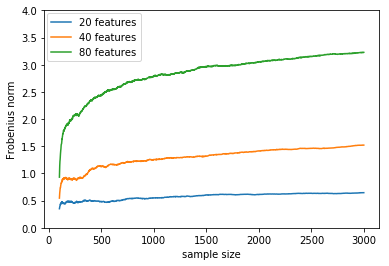

In [28]:
plt.plot(np.arange(100,n),f_diff_p20_s1,label = "20 features")
plt.plot(np.arange(100,n),f_diff_p40_s1,label = "40 features")
plt.plot(np.arange(100,n),f_diff_p80_s1,label = "80 features")
plt.ylim(0,4)
plt.xlabel('sample size')
plt.ylabel("Frobenius norm")
plt.legend(loc="upper left", borderaxespad=0.3)
plt.savefig("forb.pdf")

In [422]:
import dill                            #pip install dill --user
filename = 'simulation_seperate.pkl'
dill.dump_session(filename)

# and to load the session again:
#dill.load_session(filename)